# Natural Language Processing
<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

In [1]:
import io
import sys
import json
import os.path
import os, signal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import _pickle as pickle
import matplotlib.pyplot as plt
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#if not TF 2.x installed
#tf.enable_eager_execution()

from functions import (func_jsonParser,
                       func_TrainValidationTest_Splitter_Dataframe,
                       custom_Callback)

#-----------------------------------------------------------------------------------------------------------------#

#Main Python/module versions used here for reference
print('python:', sys.version, '\n')
print('pandas:    ', pd.__version__)
print('seaborn:   ', sns.__version__)
print('numpy:     ', np.__version__)
print('matplotlib:', mpl.__version__)
print('json:      ', json.__version__)
print('tensorflow:', tf.__version__)
print('keras:     ', keras.__version__)

tf.keras.backend.clear_session()

#-----------------------------------------------------------------------------------------------------------------#

#import warnings
#warnings.filterwarnings('ignore')

python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

pandas:     0.25.0
seaborn:    0.9.0
numpy:      1.16.4
matplotlib: 3.1.0
json:       2.0.9
tensorflow: 2.0.0-beta1
keras:      2.2.4-tf


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### MAIN CUSTOMIZABLE VARIABLES

In [2]:
VERBOSE = True                #=> (boolean) show or not additional information

CHUNK_SIZE = 10000            #=> (int) number of rows/lines to read per iteration within the function "read_json"

CHUNKS_NUM = 50               #=> (int) number of iterations to read within the function "read_json"

TEST_PERCENTANGE = 0.15       #=> (float) percentage of records to be used for training/validation and test.
    
TRAINING_PERCENTANGE = 0.75   #=> (float) percentage of training and validation records with respect to the record 
                              # set not considered for testing.

MAX_LENGHT = 250              #=> (int) maximum length of all sequences, i.e. number of words.

BINARY_CLASSIFICATION = True  #=> (boolean) if BINARY_CLASSIFICATION=True, texts are divided in positive and negative
                              #by the stars (negative <= 3 stars and positive > 3). if BINARY_CLASSIFICATION=False,
                              #a neutral lebels is considered (i.e. three clases with negative < 3 stars, neutral = 3,
                              #and positive > 3).

NUM_WORDS = 10000             #=> (int) maximum number of words to keep by the Tokenizer, based on word frequency,
                              #only the most common num_words-1 words will be kept.

EMBEDDING_DIM = 16            #=> (int) dimension of the dense embedding in the layer "tf.keras.layers.Embedding".

BATCH_SIZE = 1000             #=> (int) number of samples per gradient update during training of the sequential model.

NUM_EPOCHS = 50               #=> (int) number of iterations over data during training by the sequential model.

DROPOUT_RATE = 0.3            #=> (float) dropout rate in the layer "tf.keras.layers.Dropout".

REGULARIZATION_PARAM = 0.001  #=> (float) L2 regularization parameter in "keras.regularizers.l2" as parameter of the 
                              #layer "tf.keras.layers.Dense".

LEARNING_RATE = 0.0001        #=> (float) learning rate of the optimizer used by the sequential model.

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### LOADING AND SHUFFLING THE DATASET REVIEWS

In [3]:
print("REVIEW DATASET (# records): {}".format(sum(1 for _ in open('yelp_dataset/review.json'))))

REVIEW DATASET (# records): 6685900


In [4]:
%%time

df_review = func_jsonParser(file = 'yelp_dataset/review.json', 
                            chunk_size = CHUNK_SIZE, 
                            chunks_num = CHUNKS_NUM, 
                            save_output = True)

#shuffle the dataframe and reset the indexes
df_review = df_review.sample(frac = 1.0, random_state = 0).reset_index(drop = True)

#--------------------------------------------------------------------------------------------------------------------#

if VERBOSE:
    print(">> TOTAL NUMBER OF LINES:  {}".format(sum(1 for _ in open('yelp_dataset/review.json'))))
    print(">> LOADED DATASET (shape): {}\n".format(df_review.shape))
    print(">> COLUMN NAMES: {}".format(df_review.columns.tolist()))
    
    display(df_review.head(5))

>> TOTAL NUMBER OF LINES:  6685900
>> LOADED DATASET (shape): (500000, 9)

>> COLUMN NAMES: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,PX12y4OHqaPmWbYmc7fGuw,N-zQsz9WZs8HNu_3QGFQNA,7Ny2GHLw8xl_kXfhfrvh5w,3,0,0,0,"The food is great, portions are huge. Our ser...",2014-01-06 20:27:01
1,q3Ttz054nXXBzwjbruNlFg,D4GMqFaWTOVsVCvJi6V35w,i-Vnm8CIDZS0G815HAKCSg,1,1,0,0,This f** store is horrible. If you truly love ...,2016-09-01 15:36:58
2,8b1zraI8nxGfeI8sTNXoxg,uT8R3AXGvCZlfMr0r03YXQ,-U0liwRSHGYBEMYVj8kFmQ,2,0,0,0,For years we have infrequently enjoyed Mickey ...,2016-03-21 13:26:52
3,wjKK_e6_v6p_ur-aqCJ7XA,EysJohG8RdNdsknK93FkFA,Z_-KUIoogqjFJyLNP0TW3A,5,1,0,0,"Yep, so I shattered the screen on my iPhone 6+...",2015-04-02 20:06:10
4,yV2LULlwD6kFxwBExICcgg,BrneYLReHDmUc3NkqkL8FA,w4yq1IRk0DHQE995giqjGg,2,0,0,1,o far the server is very rude. Tables were dir...,2013-02-27 17:02:07


CPU times: user 58.9 s, sys: 13.2 s, total: 1min 12s
Wall time: 2min 37s


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### Plotting the distribution of stars on the loaded reviews

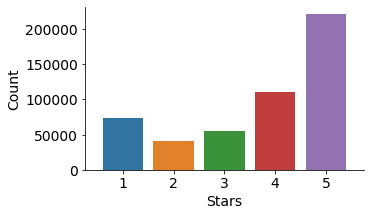

In [5]:
fig, ax = plt.subplots(figsize = (len(df_review['stars'].unique()),3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.countplot(df_review.stars)

plt.xlabel('Stars', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-0.75, len(df_review.stars.unique())-0.25)

plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### Transforming star-based rating to negative/positive (if BINARY_CLASSIFICATION = True) or negative/neutra/positive classes (if BINARY_CLASSIFICATION = False)

In [6]:
if BINARY_CLASSIFICATION:
    
    #bad comments
    df_review.loc[(df_review.stars == 1) | 
                  (df_review.stars == 2) | 
                  (df_review.stars == 3), 'stars'] = 0

    #good comments
    df_review.loc[(df_review.stars == 4) | 
                  (df_review.stars == 5), 'stars'] = 1
    
else:
    
    #bad comments
    df_review.loc[(df_review.stars == 1) | 
                  (df_review.stars == 2), 'stars'] = 0

    #indifferent comments
    df_review.loc[(df_review.stars == 3), 'stars'] = 1

    #good comments
    df_review.loc[(df_review.stars == 4) | 
                  (df_review.stars == 5), 'stars'] = 2

#--------------------------------------------------------------------------------------------------------------------#

df_review.rename(columns={"stars": "comment_qlty"}, inplace = True)

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### Plotting the resulting distribution of classes

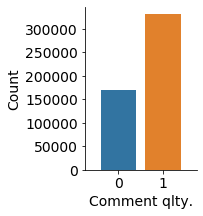

In [7]:
fig, ax = plt.subplots(figsize = (len(df_review['comment_qlty'].unique()),3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.countplot(df_review['comment_qlty'])

plt.xlabel('Comment qlty.', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlim(-0.75, len(df_review['comment_qlty'].unique())-0.25)

plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SPLITTING THE DATASET IN TRAINING, VALIDATION AND TEST SETS

In [8]:
df_training, df_validation, df_test = func_TrainValidationTest_Splitter_Dataframe(dataset = df_review,
                                                                                  test_percentage = TEST_PERCENTANGE,
                                                                                  training_percentage = TRAINING_PERCENTANGE)

training_texts = df_training["text"]
training_labls = df_training["comment_qlty"].values

validation_texts = df_validation["text"]
validation_labls = df_validation["comment_qlty"].values

test_texts = df_test["text"]
test_labls = df_test["comment_qlty"].values

del df_training, df_validation, df_test

#--------------------------------------------------------------------------------------------------------------------#

if VERBOSE:
    print(">> COMPLETE DATASET (shape):     {}".format(df_review.shape))
    print(">> TRAINING DATASET (length):    {}".format(len(training_texts)))
    print(">> VALIDATION  DATASET (length): {}".format(len(validation_texts)))
    print(">> TEST DATASET (length):        {}".format(len(test_texts)))

>> COMPLETE DATASET (shape):     (500000, 9)
>> TRAINING DATASET (length):    318750
>> VALIDATION  DATASET (length): 106250
>> TEST DATASET (length):        75000


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### TOKENIZING AND PADDING THE TRAINING, VALIDATION AND TEST TEXTS

In [9]:
%%time

tk = Tokenizer(num_words = NUM_WORDS, lower = True, oov_token = '{OOV}')
tk.fit_on_texts(training_texts.tolist())

word_indexes = tk.word_index

training_sequences = tk.texts_to_sequences(training_texts.tolist())
training_padded_sequences = pad_sequences(training_sequences, 
                                          padding = 'post', 
                                          truncating = 'post', 
                                          maxlen = MAX_LENGHT)

validation_sequences = tk.texts_to_sequences(validation_texts.tolist())
validation_padded_sequences = pad_sequences(validation_sequences, 
                                            padding = 'post', 
                                            truncating = 'post', 
                                            maxlen = MAX_LENGHT)

test_sequences = tk.texts_to_sequences(test_texts.tolist())
test_padded_sequences = pad_sequences(test_sequences, 
                                      padding = 'post', 
                                      truncating = 'post', 
                                      maxlen = MAX_LENGHT)

#--------------------------------------------------------------------------------------------------------------------#

if VERBOSE:
    print(">> WORD INDEXES (length): {}".format(len(word_indexes)))
    print(">> SOME WORD INDEXES: {}\n".format({k: word_indexes[k] for k in list(word_indexes.keys())[0:10]}))
    
    print(">> TEXT (example): {}\n".format(training_texts.tolist()[0]))
    print(">> TRAINNING SEQUENCE (example): {}\n".format(training_sequences[0]))
    print(">> TRAINNING PADDED SEQUENCES (shape): {}".format(training_padded_sequences.shape))

>> WORD INDEXES (length): 148389
>> SOME WORD INDEXES: {'{OOV}': 1, 'the': 2, 'and': 3, 'i': 4, 'a': 5, 'to': 6, 'was': 7, 'of': 8, 'it': 9, 'is': 10}

>> TEXT (example): Great service, clean restaurant and best of all the food is so, so good! I've had the chicken roti twice, and it's been amazing each time. They have affordable daily specials for just $5.25! I can't describe how much I absolutely love this place! 
It's a must try!

>> TRAINNING SEQUENCE (example): [36, 42, 216, 105, 3, 86, 8, 38, 2, 29, 10, 25, 25, 30, 96, 24, 2, 101, 3290, 623, 3, 57, 67, 117, 285, 46, 17, 22, 1103, 1431, 861, 11, 45, 131, 775, 4, 193, 2197, 123, 115, 4, 384, 93, 16, 31, 57, 5, 388, 106]

>> TRAINNING PADDED SEQUENCES (shape): (318750, 250)
CPU times: user 3min 17s, sys: 19.7 s, total: 3min 37s
Wall time: 6min 28s


<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SEQUENTIAL MODEL DEFINITION FOR BINARY OR MULTICLASS CLASSIFICATION

In [10]:
if BINARY_CLASSIFICATION:
    
    model = tf.keras.Sequential([

        tf.keras.layers.Embedding(input_dim = NUM_WORDS, 
                                  output_dim = EMBEDDING_DIM, 
                                  input_length = training_padded_sequences.shape[1],
                                  name = 'input_layer'),

        #tf.keras.layers.Flatten(name = 'hlayer1'),
        tf.keras.layers.GlobalAveragePooling1D(name = 'hlayer1'),
        
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM), name = 'hlayer1'),
        
        tf.keras.layers.Dense(units = 32, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer2'),
        
        tf.keras.layers.Dropout(rate = DROPOUT_RATE, seed = 0),
        
        tf.keras.layers.Dense(units = 16, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer3'),
        
        tf.keras.layers.Dropout(rate = DROPOUT_RATE, seed = 0),

        tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output_layer')
    ])
    
    adam = keras.optimizers.Adam(lr = LEARNING_RATE)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
else:
    
    model = tf.keras.Sequential([

        tf.keras.layers.Embedding(input_dim = NUM_WORDS, 
                                  output_dim = EMBEDDING_DIM, 
                                  input_length = training_padded_sequences.shape[1],
                                  name = 'input_layer'),

        tf.keras.layers.GlobalAveragePooling1D(name = 'hlayer1'),

        tf.keras.layers.Dense(units = 32, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer2'),
        
        tf.keras.layers.Dropout(rate = DROPOUT_RATE, seed = 0),
        
        tf.keras.layers.Dense(units = 16, 
                              activation = 'relu', 
                              kernel_regularizer = keras.regularizers.l2(REGULARIZATION_PARAM), 
                              name = 'hlayer3'),
        
        tf.keras.layers.Dropout(rate = DROPOUT_RATE, seed = 0),

        tf.keras.layers.Dense(3, activation = 'softmax', name = 'output_layer')
    ])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#--------------------------------------------------------------------------------------------------------------------#

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Embedding)      (None, 250, 16)           160000    
_________________________________________________________________
hlayer1 (GlobalAveragePoolin (None, 16)                0         
_________________________________________________________________
hlayer2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
hlayer3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### SEQUENTIAL MODEL TRAINING

In [11]:
%%time

if not os.path.isfile('model_NLP.h5'):

    history = model.fit(training_padded_sequences, 
                        training_labls, 
                        validation_data = (validation_padded_sequences, validation_labls), 
                        epochs = NUM_EPOCHS,
                        batch_size = BATCH_SIZE,
                        callbacks = [custom_Callback()],
                        verbose = 1)
    
    #model.save("model_NLP.h5")
    #print("Trainned model saved to disk!")
    
else:
    
    model = load_model('model_NLP.h5')
    print("Trainned model loaded from disk!")

W0806 02:05:42.202767 140737143739328 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 318750 samples, validate on 106250 samples
Epoch 1/50
318750/318750 [==============================] - 25s 80us/sample - loss: 0.7020 - accuracy: 0.6583 - val_loss: 0.6718 - val_accuracy: 0.6602
Epoch 2/50
318750/318750 [==============================] - 21s 65us/sample - loss: 0.6570 - accuracy: 0.6659 - val_loss: 0.6405 - val_accuracy: 0.6795
Epoch 3/50
318750/318750 [==============================] - 21s 66us/sample - loss: 0.6341 - accuracy: 0.6920 - val_loss: 0.6151 - val_accuracy: 0.7053
Epoch 4/50
318750/318750 [==============================] - 24s 76us/sample - loss: 0.6016 - accuracy: 0.7197 - val_loss: 0.5668 - val_accuracy: 0.7366
Epoch 5/50
318750/318750 [==============================] - 23s 72us/sample - loss: 0.5443 - accuracy: 0.7650 - val_loss: 0.4974 - val_accuracy: 0.7914
Epoch 6/50
318750/318750 [==============================] - 24s 75us/sample - loss: 0.4838 - accuracy: 0.8104 - val_loss: 0.4416 - val_accuracy: 0.8286
Epoch 7/50
318750/318750 [==========

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### PLOTTING MODEL PERFORMANCE DURING TRAINING

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

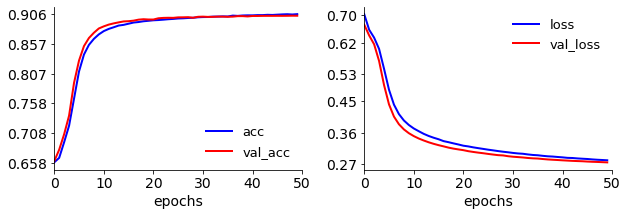

In [13]:
fig = plt.figure(figsize = (10,3))

#--------------------------------------------------------------------------------------------------------------------#

ax1 = plt.subplot(121)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.plot(np.arange(0, NUM_EPOCHS, 1), history.history['accuracy'], lw = 2, color = 'blue', label = 'acc')
plt.plot(np.arange(0, NUM_EPOCHS, 1), history.history['val_accuracy'], lw = 2, color = 'red', label = 'val_acc')

plt.xlabel('epochs', fontsize = 14)
plt.xticks(np.arange(0, (1.1 * NUM_EPOCHS), NUM_EPOCHS/5), fontsize = 14)
miny = np.min([np.min(history.history['accuracy']), np.min(history.history['val_accuracy'])])
maxy = np.max([np.max(history.history['accuracy']), np.max(history.history['val_accuracy'])])
plt.yticks(np.round(np.arange(miny, (1.01 * maxy), (maxy - miny)/5), 3), fontsize = 14)
plt.xlim(0, NUM_EPOCHS)
plt.legend(loc = 'lower right', frameon = False, fontsize = 13)

#----------------------------------------------------#

ax2 = plt.subplot(122)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.plot(np.arange(0, NUM_EPOCHS, 1), history.history['loss'], lw = 2, color = 'blue', label = 'loss')
plt.plot(np.arange(0, NUM_EPOCHS, 1), history.history['val_loss'], lw = 2, color = 'red', label = 'val_loss')

plt.xlabel('epochs', fontsize = 14)
plt.xticks(np.arange(0, (1.1 * NUM_EPOCHS), NUM_EPOCHS/5), fontsize = 14)
miny = np.min([np.min(history.history['loss']), np.min(history.history['val_loss'])])
maxy = np.max([np.max(history.history['loss']), np.max(history.history['val_loss'])])
plt.yticks(np.round(np.arange(miny, (1.1 * maxy), (maxy - miny)/5), 2), fontsize = 14)
plt.xlim(0, NUM_EPOCHS)
plt.legend(loc = 'upper right', frameon = False, fontsize = 13)

#--------------------------------------------------------------------------------------------------------------------#

plt.subplots_adjust(wspace = 0.25)
plt.show()

<hr style="width:100%; height:20px; border:none; color:#ffffff; background-color:#000000;">

### MODEL PERFORMANCE ON THE UNSEEN TEST DATA

In [14]:
loss_val, metric_val = model.evaluate(test_padded_sequences, test_labls)

75000/75000 [==============================] - 8s 102us/sample - loss: 0.2725 - accuracy: 0.9055


<hr style="width:100%; height:10px; border:none; color:#ffffff; background-color:#000000;">

### SAVING OUTPUTS FOR EMBEDDING VISUALIZATION (RESULTING POLARIZATION OF WORDS)

In [15]:
reverse_word_index = dict([(v, k) for (k, v) in word_indexes.items()])
weights = model.layers[0].get_weights()[0]

#metadata file
words_file = io.open('metada.tsv', 'w', encoding = 'utf-8')
#vectors file
weights_file = io.open('vectors.tsv', 'w', encoding = 'utf-8')

for i in range(1, NUM_WORDS):
    
    words_file.write(reverse_word_index[i] + "\n")
    weights_file.write('\t'.join([str(x) for x in weights[i]]) + "\n")

words_file.close()
weights_file.close()

# i) Go to https://projector.tensorflow.org/
# ii) Load the medatada and vectors files 
# iii) Sphereize data, i.e the data is normalized by shifting each point by the centroid and making it unit norm.

In [16]:
#os.kill(os.getpid(), signal.SIGKILL)